In [45]:
import sys
import os
sys.path.insert(0, '../magcolloids')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import HTML, clear_output
import scipy.optimize as spo
import scipy.spatial as spa 
import magcolloids as mgc
import matplotlib as mpl
import string as st
import support as sp

from tqdm.auto import tqdm

ureg = mgc.ureg

idx = pd.IndexSlice

%reload_ext autoreload
%autoreload 2

In [46]:
mpl.rc("figure",dpi=150)
mpl.rc("figure",figsize=(3,2))
mpl.rc("text",usetex=True)

In [47]:
%%time
directory = "/media/Antonio/Dynamic/DimerCurrents/Processed"

aggregate_file = os.path.join(directory, "23_08_01_Script10_currents_vs_time.hdf")
data_IvsT = pd.read_hdf(aggregate_file,
                 key = "current_vs_time")
data_IvsT = data_IvsT.reorder_levels(["parity","tilt","seed","time"]).sort_index()

trayectories_file = os.path.join(directory, "23_08_01_Script10_currents.hdf")
index = pd.read_hdf(trayectories_file,
                 key = "index")

CPU times: user 989 ms, sys: 771 ms, total: 1.76 s
Wall time: 26.3 s


In [48]:
data_IvsT.head()

I_x        I_y      var_x     var_y    N
parity tilt seed  time                                                  
even   0    61169 0.0000        NaN        NaN        NaN       NaN    0
                  0.0167  22.159485   6.018671  19.609173  6.862368  239
                  0.0334  20.559523  10.903647   9.871448  4.742351  239
                  0.0501   3.946854   3.128267   7.338341  6.362692  239
                  0.0668  -6.237284  -4.518595   7.420936  6.416721  239

In [49]:
data_IvsT["I"]=data_IvsT.rolling(20).mean().eval("sqrt(I_x**2+I_y**2)")

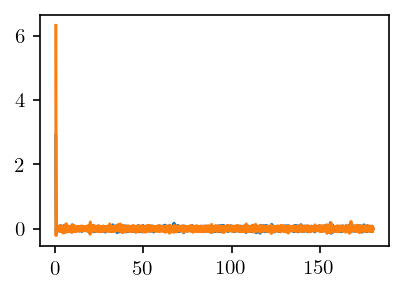

In [51]:
plt.plot(data_IvsT.loc["even"].loc[0].loc[61169].I_x.rolling(20).mean())
plt.plot(data_IvsT.loc["even"].loc[0].loc[61169].I_y.rolling(20).mean())

(-0.2, 0.2)

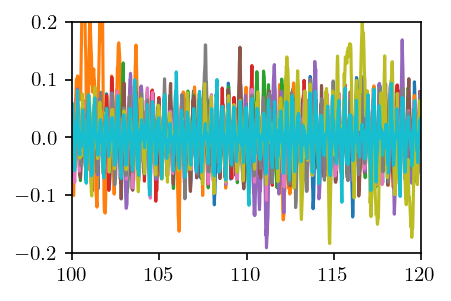

In [52]:
for seed, I_i in data_IvsT.loc[("even",0)].groupby("seed"):
    plt.plot(I_i.loc[seed].I_x.rolling(20).mean())
    
plt.xlim([100,120])
plt.ylim(-0.2,0.2)

In [56]:
currents_aggregate = data_IvsT.groupby(["parity","tilt","time"]).mean()
currents_aggregate[["I_x","I_y"]] = currents_aggregate.rolling(20).mean()[["I_x","I_y"]]

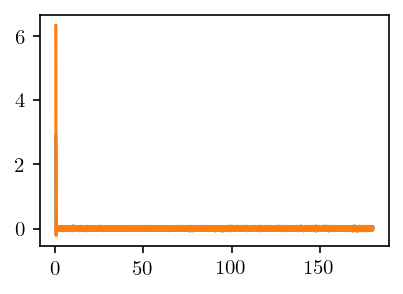

In [60]:
plt.plot(currents_aggregate["I_x"].loc[("even",0)])
plt.plot(currents_aggregate["I_y"].loc[("even",0)])

In [61]:
currents_aggregate.head()

I_x  I_y      var_x     var_y      N   I
parity tilt time                                            
even   0    0.0000  NaN  NaN        NaN       NaN    0.0 NaN
            0.0167  NaN  NaN  19.616164  7.644044  239.0 NaN
            0.0334  NaN  NaN  10.105327  5.243471  239.0 NaN
            0.0501  NaN  NaN   7.511600  6.421853  239.0 NaN
            0.0668  NaN  NaN   6.705355  5.989137  239.0 NaN

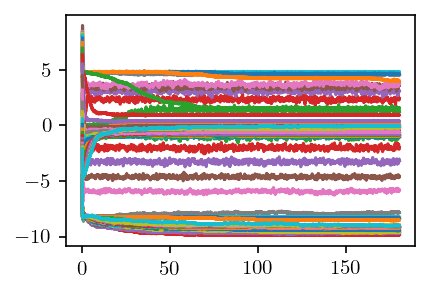

In [62]:
for i, data_i in currents_aggregate.loc["even"].groupby("tilt"):
    L = plt.plot(currents_aggregate.loc["even"].loc[i].I_x)
    plt.plot(currents_aggregate.loc["even"].loc[i].I_y,
            color = L[0].get_color())

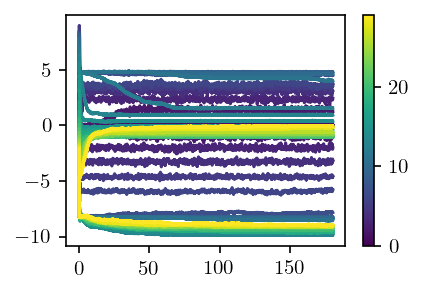

In [66]:
tilts = data_IvsT.index.get_level_values("tilt").unique()
cmap = mpl.colormaps["viridis"]
norm = mpl.colors.Normalize(min(tilts), max(tilts))

for i, data_i in currents_aggregate.loc["even"].groupby("tilt"):
    plt.plot(currents_aggregate.loc[("even",i)].I_x,
            color = cmap(norm(i)))
    plt.plot(currents_aggregate.loc[("even",i)].I_y,
            color = cmap(norm(i)))
    
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax = plt.gca())

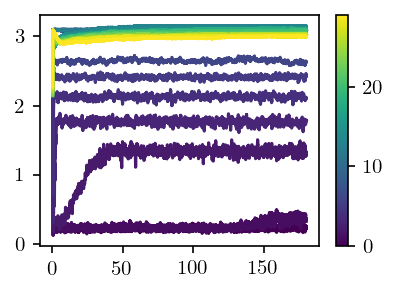

In [67]:
tilts = data_IvsT.index.get_level_values("tilt").unique()
cmap = mpl.colormaps["viridis"]
norm = mpl.colors.Normalize(min(tilts), max(tilts))

for i, data_i in currents_aggregate.loc["even"].groupby("tilt"):
    
    I = np.sqrt(currents_aggregate.loc[("even",i)].I)

    plt.plot(I,color = cmap(norm(i)))
    
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax = plt.gca())

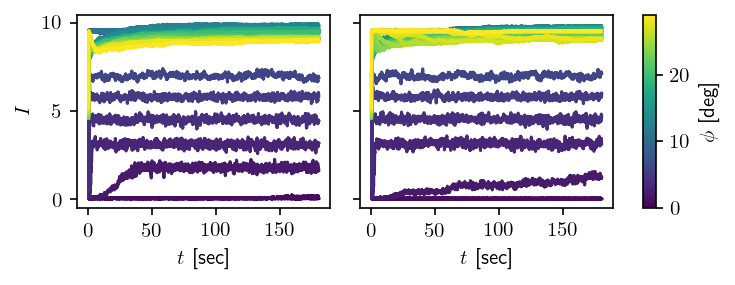

In [68]:
fig, ax = plt.subplots(1,3, figsize=(5,2),
                       width_ratios = [1,1, 0.05],
                       tight_layout=True)

tilts = data_IvsT.index.get_level_values("tilt").unique()
cmap = mpl.colormaps["viridis"]
norm = mpl.colors.Normalize(min(tilts), max(tilts))

for i, data_i in currents_aggregate.loc["even"].groupby("tilt"):

    ax[0].plot(currents_aggregate.loc[("even",i)].I ,color = cmap(norm(i)))
    
    ax[1].plot(currents_aggregate.loc[("odd",i)].I ,color = cmap(norm(i)))
    
    
ax[0].set_ylabel("$I$")
ax[0].set_xlabel("$t$ [sec]")
ax[1].set_xlabel("$t$ [sec]")

ax[1].set_ylim(ax[0].get_ylim())
ax[1].tick_params("y",labelleft=False)
#ax[1].set_yticks([])
    
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax = ax[2],
             label = "$\phi$ [deg]")


### Save the smooth dataset

In [69]:
currents_aggregate.to_hdf(aggregate_file,
                 key = "current_vs_time_smooth")

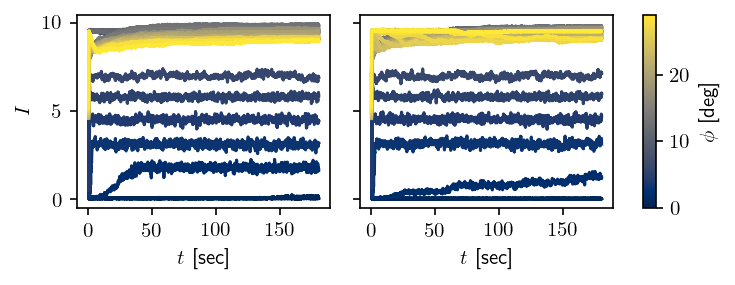

In [70]:
data_IvsT_smooth = pd.read_hdf(aggregate_file,
                 key = "current_vs_time_smooth")

fig, ax = plt.subplots(1,3, figsize=(5,2),
                       width_ratios = [1,1, 0.05],
                       tight_layout=True, facecolor="white")

tilts = data_IvsT.index.get_level_values("tilt").unique()
cmap = mpl.colormaps["cividis"]
norm = mpl.colors.Normalize(min(tilts), max(tilts))

for phi in np.sort(tilts):

    ax[0].plot(data_IvsT_smooth.loc["even"].loc[phi].I, color = cmap(norm(phi)))

    ax[1].plot(data_IvsT_smooth.loc["odd"].loc[phi].I, color = cmap(norm(phi)))
    
    
ax[0].set_ylabel("$I$")
ax[0].set_xlabel("$t$ [sec]")
ax[1].set_xlabel("$t$ [sec]")

ax[1].set_ylim(ax[0].get_ylim())
ax[1].tick_params("y",labelleft=False)
#ax[1].set_yticks([])
    
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax = ax[2],
             label = "$\phi$ [deg]")


# Visualize final value of the current vs tilt angle $\phi$

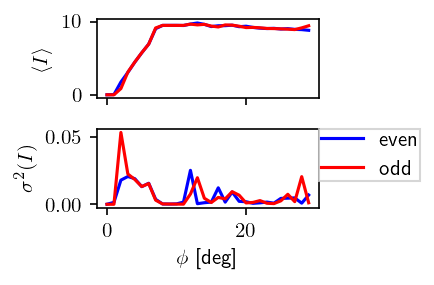

In [71]:
data_IvsPhi = data_IvsT_smooth.query("time>50").groupby(["parity","tilt"]).mean()

fig, ax = plt.subplots(2,1, sharex=True,
                       figsize=(3,2), facecolor="white",
                       tight_layout=True)

color = ["blue","red"]

ax[0].plot(data_IvsPhi.loc["even"].I,color = color[0])
ax[0].plot(data_IvsPhi.loc["odd"].I,color = color[1])

data_IvsPhi_var = data_IvsT_smooth.query("time>50").groupby(["parity","tilt"]).var()

ax[1].plot(data_IvsPhi_var.loc["even"].I, color[0], label="even")
ax[1].plot(data_IvsPhi_var.loc["odd"].I, color[1], label="odd")

ax[1].set_xlabel("$\phi$ [deg]")
ax[1].set_ylabel("$\sigma^2(I)$")
ax[0].set_ylabel(r"$\left<I\right>$")

ax[1].legend(
    fancybox=False,
    borderpad=0.1,
    bbox_to_anchor=(1,1),borderaxespad=0
            )